In [3]:
### Illustration du biais de regularisation
### Dernière modification: 23/05/2020
### Jérémy L'Hour


rm(list=ls())

##############################
##############################
### PACKAGES AND FUNCTIONS ###
##############################
##############################

library("MASS")
library("glmnet")
library("ggplot2")
library("gridExtra")

### FONCTIONS
source("functions/DataSim.R") 

# POST-LASSO
PostLasso <- function(X,y,nopen){
    #'@param nopen indices des variables a ne pas penaliser
    phi = rep(1,ncol(X)); phi[nopen] = 0 # penalty loadings
    # ETAPE 1
    cv.lasso = cv.glmnet(X,y, family="gaussian",alpha=1,penalty.factor=phi,nfolds=5)
    b.lasso = coef(cv.lasso); b.lasso = b.lasso[-1] # on enleve la constante
    s.hat = which(b.lasso != 0) # indices des variables actives parmi les X
    # ETAPE 2
    postlasso = lm(y ~ X[,s.hat])
    
    return(list(coef = coef(postlasso),
               se = summary(postlasso)$coefficients[,"Std. Error"])
           )
}

# POST-STUDENT
PostStudent <- function(X,y,nopen,alpha=.05){
    #'@param nopen indices des variables a ne pas penaliser
    #'@param alpha niveau de significativite pour selection
    # ETAPE 1
    fullreg = lm(y ~ X)
    s.hat = summary(fullreg)$coef[,"Pr(>|t|)"] < alpha
    s.hat = which(s.hat[-1] == T)
    s.hat = union(nopen,s.hat)
    # ETAPE 2
    shortreg = lm(y ~ X[,s.hat])

    return(list(coef = coef(shortreg),
               se = summary(shortreg)$coefficients[,"Std. Error"])
          )
}

Loading required package: Matrix

Loaded glmnet 3.0-2




In [4]:
######################
######################
### 1. SIMULATIONS ### 
######################
######################

R = 20 # nb simulations
n = 200 # sample size
p = 300 # nb variables
tau = .5 # vraie valeur de l'effet

set.seed(999)
estimate = matrix(ncol=4, nrow=R)
standard_error = matrix(ncol=4, nrow=R)

In [5]:
t_start = Sys.time()

for(r in 1:R){
  ### GENERATE DATA
  data = DataSim(n=n,p=p,Ry=.1,Rd=.8,Intercept=F,a=tau)
  X = cbind(data$d,data$X); y = data$y
  
  ### METHOD 1: Oracle
  oracle.reg = lm(y ~ X[,1:(abs(p/2)+1)])
    
  ### METHOD 2: Modele complet
  full.reg = lm(y ~ X)

  ### METHOD 3: Selection Lasso
  lasso.reg = PostLasso(X,y,nopen=c(1))
  
  ### METHOD 4: Selection sur la stat de Student
  student.reg = PostStudent(X,y,nopen=c(1),alpha=.01)
  
  ### COLLECTING RESULTS
  estimate[r,] = c(oracle.reg$coef[2],
                  full.reg$coef[2],
                  lasso.reg$coef[2],
                  student.reg$coef[2])
    
  standard_error[r,] = c(summary(oracle.reg)$coefficients[2,"Std. Error"],
                         summary(full.reg)$coefficients[2,"Std. Error"],
                         lasso.reg$se[2],
                         student.reg$se[2])
}

print(Sys.time()-t_start)

Time difference of 7.447688 secs


In [24]:
################################
################################
### 2. COMPUTE BIAS AND RMSE ###
################################
################################

StatDisplay = data.frame()
StatDisplay[1:4,"Bias"] = apply(estimate-tau,2,mean)
StatDisplay[1:4,"RMSE"] = sqrt(apply((estimate-tau)^2,2,mean))

borne_sup = estimate + qnorm(.975) * standard_error - tau
borne_inf = estimate - qnorm(.975) * standard_error - tau
StatDisplay[1:4,"Coverage rate"] = apply((borne_sup>0)*(borne_inf<0),2,mean,na.rm=T)

row.names(StatDisplay) = c("Oracle","Complet","Post-Lasso","Post-Student")
print(round(StatDisplay, digits=3))

               Bias  RMSE Coverage rate
Oracle       -0.001 0.192         0.951
Complet       0.001 0.217         0.944
Post-Lasso    0.339 0.432         0.312
Post-Student  0.084 0.274         0.774


Warning message:
“Removed 2 rows containing missing values (geom_bar).”
Warning message:
“Removed 2 rows containing missing values (geom_bar).”
Warning message:
“Removed 2 rows containing missing values (geom_bar).”
Warning message:
“Removed 2 rows containing missing values (geom_bar).”


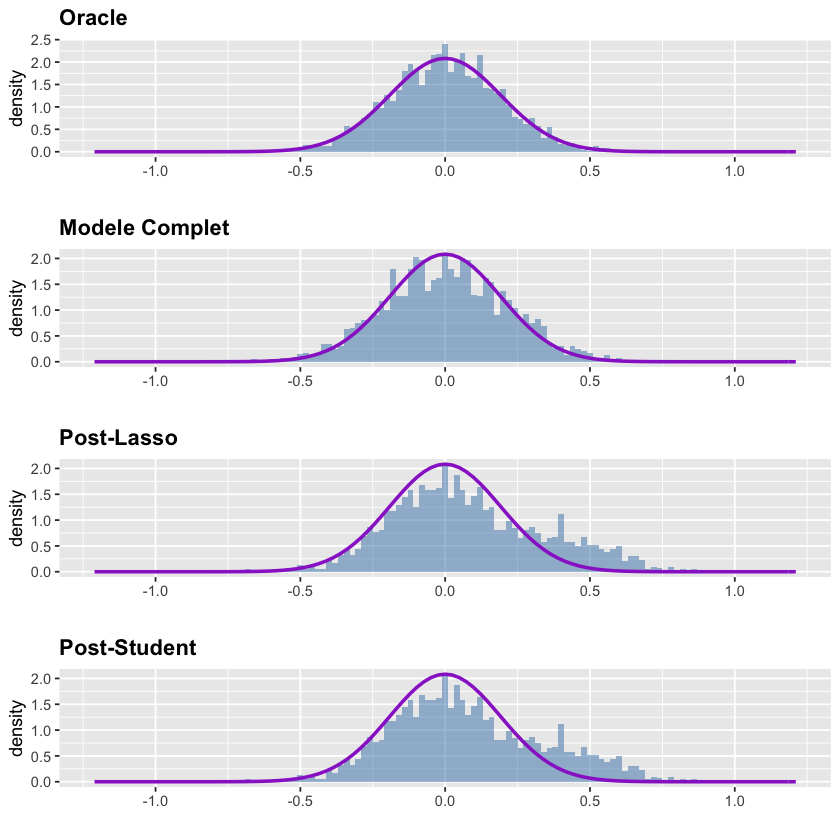

In [23]:
#######################
#######################
### 3. DRAW CHARTS ####
#######################
#######################

id = c(mapply(function(x) rep(x,R),1:4))
val = c(estimate)-tau
data_res = data.frame(val = val, model = id)

M = max(abs(quantile(estimate,.01,na.rm=T)),abs(quantile(estimate,.99,na.rm=T)))
lb = -1*M; ub = 1*M

get.plot <- function(data,modelS,title="A Title",s){
  plot_res <- ggplot(subset(data, (model==modelS)), aes(x=val)) + 
    geom_histogram(binwidth = .02, alpha=.5, position='identity',fill="steelblue", aes(y = ..density..)) +
    scale_x_continuous(limits=c(lb,ub), name=" ") +
    ggtitle(title) + 
    stat_function(fun = dnorm, args=list(mean=0, sd=s), colour="darkorchid3", size=1) +
    theme(plot.title = element_text(lineheight=.8, face="bold"),legend.position="none")
  return(plot_res)
} # plot func


grid.arrange(get.plot(data_res,1,"Oracle", StatDisplay[1,2]), 
             get.plot(data_res,2,"Modele Complet", StatDisplay[1,2]), 
             get.plot(data_res,4,"Post-Lasso",  StatDisplay[1,2]), 
             get.plot(data_res,4,"Post-Student",  StatDisplay[1,2]), ncol=1)

In [27]:
pdf("regbiasimulations.pdf",width=10,height=8)
grid.arrange(get.plot(data_res,1,"Oracle", StatDisplay[1,2]), 
             get.plot(data_res,2,"Modele Complet", StatDisplay[1,2]), 
             get.plot(data_res,4,"Post-Lasso",  StatDisplay[1,2]), 
             get.plot(data_res,4,"Post-Student",  StatDisplay[1,2]), ncol=2, nrow=2)
dev.off()

Warning message:
“Removed 2 rows containing missing values (geom_bar).”
Warning message:
“Removed 2 rows containing missing values (geom_bar).”
Warning message:
“Removed 2 rows containing missing values (geom_bar).”
Warning message:
“Removed 2 rows containing missing values (geom_bar).”


pdf 
  2